In [1]:
from keras.utils import to_categorical
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

data_train = pd.read_csv('input/fashion-mnist_train.csv')
data_test = pd.read_csv('input/fashion-mnist_test.csv')

batch_size = 100
num_classes = 10
epochs = 20

img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

X = np.array(data_train.iloc[:, 1:])
y = to_categorical(np.array(data_train.iloc[:, 0]))

#Here we split validation data to optimiza classifier during training
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

#Test data
X_test = np.array(data_test.iloc[:, 1:])
y_test = to_categorical(np.array(data_test.iloc[:, 0]))

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
X_train /= 255
X_test /= 255
X_val /= 255

/home/lam/anaconda2/envs/tf15/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from imgaug import augmenters as iaa

sometimes = lambda aug: iaa.Sometimes(0.5, aug)
# seq = iaa.Sequential([iaa.Fliplr(0.5), sometimes(iaa.Affine(rotate=(-5, 5), shear=(-5, 5)))])
seq = iaa.Sequential([iaa.Fliplr(0.5)])
X_train = seq.augment_images(X_train)

In [3]:
from keras import layers, models, optimizers
from keras import backend as K
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask

K.set_image_data_format('channels_last')

x = layers.Input(shape=input_shape)

# Layer 1: Just a conventional Conv2D layer
conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

# Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

# Layer 3: Capsule layer. Routing algorithm works here.
digitcaps = CapsuleLayer(num_capsule=num_classes, dim_capsule=16, num_routing=3,
                         name='digitcaps')(primarycaps)

# Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
# If using tensorflow, this will not be necessary. :)
out_caps = Length(name='capsnet')(digitcaps)

# Decoder network.
y = layers.Input(shape=(num_classes,))
masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

# Shared Decoder model in training and prediction
decoder = models.Sequential(name='decoder')
decoder.add(layers.Dense(512, activation='relu', input_dim=16*num_classes))
decoder.add(layers.Dense(1024, activation='relu'))
decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

# Models for training and evaluation (prediction)
model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
eval_model = models.Model(x, [out_caps, decoder(masked)])

In [4]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 256)  20992       input_1[0][0]                    
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 6, 6, 256)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 1152, 8)      0           primarycap_conv2d[0][0]          
__________________________________________________________________________________________________
primarycap

In [5]:
from keras.callbacks import ModelCheckpoint
import os

outpath = "Capsnet"
if not os.path.exists(outpath):
    os.mkdir(outpath)
filepath= outpath + "/weights-improvement-{epoch:02d}-{val_capsnet_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_capsnet_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [6]:
eval_model.load_weights(outpath + "/weights-improvement-03-0.91.hdf5")
y_pred, x_recon = eval_model.predict(X_test, batch_size=batch_size)
print('-'*50)
print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])

--------------------------------------------------
Test acc: 0.9163



Reconstructed images are saved to ./real_and_recon.png
--------------------------------------------------


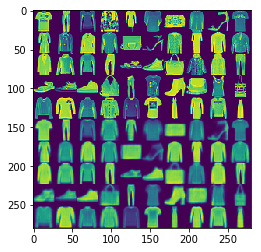

In [8]:
import matplotlib.pyplot as plt
from utils import combine_images
from PIL import Image

img = combine_images(np.concatenate([X_test[:50],x_recon[:50]]))
image = img * 255
Image.fromarray(image.astype(np.uint8)).save("real_and_recon.png")
print()
print('Reconstructed images are saved to ./real_and_recon.png')
print('-'*50)
plt.imshow(plt.imread("real_and_recon.png", ))
plt.show()